In [1]:
%pylab inline
#Autoreload so changing py files works
%load_ext autoreload
%autoreload 2
from Util import *
from superpoint import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
skip = 20
putin = loadVideoFrames('data/Putin Watching TV.mp4', max_frames=4, frame_skip=skip, gray=True, datatype='float32')
putinc = loadVideoFrames('data/Putin Watching TV.mp4', max_frames=4, frame_skip=skip, datatype='float32')
putinc2 = loadVideoFrames('data/Putin Watching TV.mp4', max_frames=4, frame_skip=skip, normal=False)

Loaded in: 0.48302769660949707
Loaded in: 0.6020345687866211
Loaded in: 0.5080289840698242


In [3]:
spoint = SuperPointFrontend(weights_path='superpoint_v1.pth',
                      nms_dist=4,
                      conf_thresh=0.05,
                      nn_thresh=0.7,
                      cuda=False)

In [5]:
pts1, desc1, heatmap1 = spoint.run(putin[0])
pts2, desc2, heatmap2 = spoint.run(putin[1])

In [6]:
def drawMatches(image1, image2, kps1, kps2, matches):
    # initialize the output visualization image
    (h1, w1) = image1.shape[:2]
    (h2, w2) = image2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")
    vis[0:h1, 0:w1] = image1
    vis[0:h2, w1:] = image2
    
    pointsx1 = kps1[0]
    pointsy1 = kps1[1]
    pointsx2 = kps2[0]
    pointsy2 = kps2[1]
    points1 = []
    points2 = []
    
    # loop over the matches
    for i in range(len(matches)):
        # draw the match
        dm_l = matches[i]
        dm = dm_l[0]
        queryIdx = dm.queryIdx
        trainIdx = dm.trainIdx
        
        pt1 = (int(pointsx1[queryIdx]), int(pointsy1[queryIdx]))
        pt2 = (int(pointsx2[trainIdx]) + w1, int(pointsy2[trainIdx]))
        points1.append(pt1)
        points2.append(pt2)
        cv2.line(vis, pt1, pt2, (0, 255, 0), 1)

    # return the visualization
    return vis, np.array(points1), np.array(points2)


pTracker = PointTracker(2,0.7)
matchesSP = pTracker.nn_match_two_way(desc1, desc2, 0.4)
key_ps1 = []
key_ps2 = []
for i in range(pts1.shape[1]):
    key_ps1.append(cv2.KeyPoint(pts1[0][i], pts1[1][i], _size=5, _response=1, _octave=0, _class_id=0))

for i in range(pts2.shape[1]):
    key_ps2.append(cv2.KeyPoint(pts2[0][i], pts2[1][i], _size=5, _response=1, _octave=0, _class_id=1))
dMatchesSP = []
for i in range(matchesSP.shape[1]):
    dmatch = cv2.DMatch()
    dmatch.queryIdx=int(matchesSP[1][i])
    dmatch.trainIdx=int(matchesSP[0][i])
    dmatch.distance=matchesSP[2][i]
    dMatchesSP.append([dmatch])
vis, points2, points1 = drawMatches(image1=putinc2[1], image2=putinc2[0], kps1=pts2, kps2=pts1,matches=dMatchesSP)
HG, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

stitched = cv2.warpPerspective(putinc[1], HG, (putin[0].shape[1]+putin[1].shape[1], putin[1].shape[0]))

In [ ]:
import time
def findHomography(ims, spoint):
    kps = []
    descs = []
    for i in range(len(ims)):
        key_ptsi, descsi, heatmapi = spoint.run(ims[i])
        kps.append(key_ptsi)
        descs.append(descsi)
    return kps, descs
start = time.time()
kps, descs = findHomography(putin, spoint)
end = time.time()
print("Keypoints and Descriptors found in: " + str(end - start))
print(len(kps))
print(len(putin))
#TAKES TOO LONG!!!!!

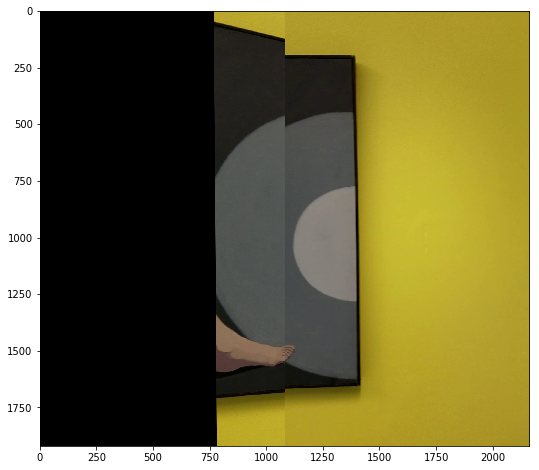

In [7]:
stitched[0:putin[0].shape[0], putin[1].shape[1]:] = putinc[0]
fig = figure(figsize = (12,8))
imshow(stitched)